In [1]:
!pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    

In [3]:
import os
import random
import numpy as np
import simpy
import pandas as pd
import scipy.stats as st
RANDOM_SEED = 41
from tqdm import tqdm

In [5]:
from scipy.stats import fatiguelife
from scipy.stats import rayleigh
from scipy.stats import burr
from scipy.stats import gumbel_r

'''
충전시간의 분포는 다음과 같다.

fatiguelife.rvs(0.2861303,loc= -50.2668303, scale=101.7351567)
np.random.rayleigh(scale=46.62645)
burr.rvs(3.570477378,1.715625801, scale=1/0.003504229)
gumbel_r.rvs(loc=83.92523, scale = 63.17503)
'''


'\n충전시간의 분포는 다음과 같다.\n\nfatiguelife.rvs(0.2861303,loc= -50.2668303, scale=101.7351567)\nnp.random.rayleigh(scale=46.62645)\nburr.rvs(3.570477378,1.715625801, scale=1/0.003504229)\ngumbel_r.rvs(loc=83.92523, scale = 63.17503)\n'

In [ ]:
class LineLogger():
    """
    logs the size of a resource line
    """

    def __init__(self, env):
        self.env = env

        # the log
        self.samples_df = pd.DataFrame(columns=['time','len'])

    def log(self, time, len):
        """
        log a time and length of the resoure request queue

        time:   time the messure is taken
        len:    length of the queue
        """
        #마지막에 행 추가 
        self.samples_df = self.samples_df.append({'time':time,'len':len},ignore_index=True)

    def remove(self):

        #맨 마지막 행 삭제 
        self.samples_df.drop(self.samples_df.tail(1).index,inplace=True) 

    def get_ave_line(self):
        """
        finds the time weighted average of the queue length
        """
        # use the next row to figure out how long the queue was at that length
        self.samples_df['time_span'] = self.samples_df['time'].shift(-1) - self.samples_df['time']

        # drop the last row because it would have a infinate time span
        trimed_samples_df = self.samples_df[0:-1]

        ave = np.average(trimed_samples_df['len'], weights=trimed_samples_df['time_span'])

        return ave

In [ ]:
class Carcharge(object):
 
    def __init__(self, env, num_Fast,num_Slow):
        self.env = env
        self.fast_charger = simpy.Resource(env, num_Fast)
        self.slow_charger = simpy.Resource(env, num_Slow)

    def charge_fast(self):
        if self.env.now <5760:      #평일 급속
            fast_service_time = max(fatiguelife.rvs(0.2861303, loc= -50.2668303, scale=101.7351567),0)
        else:                       #주말 급속
            fast_service_time = max(np.random.rayleigh(scale=46.62645),0)

        yield self.env.timeout(fast_service_time)

    def charge_slow(self):
        if self.env.now <5760:      #평일 완속
            slow_service_time = max(burr.rvs(3.570477378,1.715625801, scale=1/0.003504229),0)
        else:                       #주말 완속
            slow_service_time = max(gumbel_r.rvs(loc=83.92523, scale = 63.17503),0)

        yield self.env.timeout(slow_service_time)


In [ ]:
def car(env, name, charge, category):

    global numqueue, queue, delay_time, real_fast, real_slow, fast_logger, slow_logger
    '''
    print('%s arrives at the 충전기 at %.2f.' % (name, env.now))
    '''

    arrival_timestamp = env.now
    queue.append(name)
    '''
    print('현재 대기열:' , queue)
    '''

    if category == 'fast':

        if (charge.fast_charger.capacity - charge.fast_charger.count) !=0:  #급속에 자리 있을 때

            with charge.fast_charger.request() as request: #request를 하는 동시에 get을 하게 돼 > 이미 queue가 생김 

                # requester enters queue for resouce
                fast_logger.log(env.now,len(charge.fast_charger.queue))

                yield request

                # requester got a resource and leaves requeuest queue
                # if the resource was available when the request was made, then time in queue will be 0
                fast_logger.log(env.now,len(charge.fast_charger.queue))

                real_fast += 1

                start_timestamp = env.now
                #################
                length= charge.fast_charger.count
                time_in_fast.append(start_timestamp)
                len_in_fast.append(length)
                ######################

                delay = start_timestamp - arrival_timestamp
                delay_time.append(delay)
        

                queue.remove(name)
                '''
                print('%s starts fast charging at %.2f.' % (name, env.now) , ' 현재 대기열: ', queue)
                '''
                yield env.process(charge.charge_fast())
                ###############
                end_timestamp = env.now
                
                length= charge.fast_charger.count
                time_in_fast.append(end_timestamp)
                len_in_fast.append(length)
                #####################
                
                '''
                print('%s leaves the fast charger at %.2f.' % (name, env.now))
                '''  

        else: #급속 자리 없을때
            
            if (charge.slow_charger.capacity -  charge.slow_charger.count) !=0:  #급속 자리 없는데 완속 있을 때
                with charge.slow_charger.request() as request:


                    slow_logger.log(env.now,len(charge.slow_charger.queue))
                    yield request
                    slow_logger.log(env.now,len(charge.slow_charger.queue))

                    real_slow += 1

                    start_timestamp = env.now
                    #추가분####################
                    length= charge.slow_charger.count
                    time_in_slow.append(start_timestamp)
                    len_in_slow.append(length)
                    ###########################################

                    delay = start_timestamp - arrival_timestamp
                    delay_time.append(delay)
        

                    queue.remove(name)
                    '''
                    print('%s starts slow charging at %.2f.' % (name, env.now), ' 현재 대기열: ', queue)
                    '''
                    yield env.process(charge.charge_slow())
                    end_timestamp = env.now
                    ###############
                    length= charge.slow_charger.count
                    time_in_slow.append(end_timestamp)
                    len_in_slow.append(length)
                    #####################
                    '''
                    print('%s leaves the slow charger at %.2f.' % (name, env.now))
                    '''

            else:  
                            #둘다 Request 날리기 
                fast_req = charge.fast_charger.request()
                slow_req = charge.slow_charger.request()
                any_of_request = [fast_req,slow_req]

                available_request = simpy.events.AnyOf(env, any_of_request)

                fast_logger.log(env.now,len(charge.fast_charger.queue))
                slow_logger.log(env.now,len(charge.slow_charger.queue))

                captured_requests = yield available_request

                start_timestamp = env.now

                delay = start_timestamp - arrival_timestamp
                delay_time.append(delay)

                queue.remove(name)


            # how do i determine what unit was captured by the request?
            # it is possible that both resources are avaliable
            # and both request get filled

                captured_requests = list(captured_requests.keys())
                captured_request = captured_requests[0]

                if captured_request == fast_req: #급속 선택
                    slow_req.cancel() #완속 요청 취소
                    slow_logger.remove() #완속 마지막 행 삭제(아까 추가한 것)

                    ##########
                    length= charge.fast_charger.count
                    time_in_fast.append(start_timestamp)
                    len_in_fast.append(length)
                    ##############

                    real_fast += 1
                    fast_logger.log(env.now,len(charge.fast_charger.queue))
                    '''
                    print('%s starts fast charging at %.2f.' % (name, env.now) , ' 현재 대기열: ', queue)
                    '''
                    yield env.process(charge.charge_fast())
                    #############
                    end_timestamp = env.now
                    length= charge.fast_charger.count
                    time_in_fast.append(end_timestamp)
                    len_in_fast.append(length)
                    ##########

                    charge.fast_charger.release(fast_req) #급속 쓰고나서는 방출
                    '''
                    print('%s leaves the fast charger at %.2f.' % (name, env.now))
                    '''

                else: #완속 선택
                    fast_req.cancel() #급속 요청 취소 
                    fast_logger.remove() #급속 마지막 행 삭제(아까 추가한 것)
                    ##########
                    length= charge.slow_charger.count
                    time_in_slow.append(start_timestamp)
                    len_in_slow.append(length)
                    ############## 

                    real_slow += 1
                    slow_logger.log(env.now,len(charge.slow_charger.queue))
                    '''
                    print('%s starts slow charging at %.2f.' % (name, env.now), ' 현재 대기열: ', queue)
                    '''
                    yield env.process(charge.charge_slow())
                    #############
                    end_timestamp = env.now
                    length= charge.slow_charger.count
                    time_in_slow.append(end_timestamp)
                    len_in_slow.append(length)
                    ##########

                    charge.slow_charger.release(slow_req) #완속 쓰고나서는 방출 
                    '''
                    print('%s leaves the slow charger at %.2f.' % (name, env.now))
                    '''



    if category == 'slow':
        if (charge.slow_charger.capacity -  charge.slow_charger.count) !=0:  #완속에 자리 있을 때

            with charge.slow_charger.request() as request:

                slow_logger.log(env.now,len(charge.slow_charger.queue))

                yield request

                slow_logger.log(env.now,len(charge.slow_charger.queue))

                real_slow += 1

                start_timestamp = env.now
                ##########
                length= charge.slow_charger.count
                time_in_slow.append(start_timestamp)
                len_in_slow.append(length)
                ##############

                delay = start_timestamp - arrival_timestamp
                delay_time.append(delay)

                queue.remove(name)
                '''
                print('%s starts slow charging at %.2f.' % (name, env.now), ' 현재 대기열: ', queue)
                '''
                yield env.process(charge.charge_slow())
                ##########
                end_timestamp = env.now
                length= charge.slow_charger.count
                time_in_slow.append(end_timestamp)
                len_in_slow.append(length)
                ##############

                '''
                print('%s leaves the slow charger at %.2f.' % (name, env.now))
                '''

        else: #완속 자리 없을 때 
            
            if (charge.fast_charger.capacity -  charge.fast_charger.count) !=0:  #완속 자리 없는데 급속 있을 때
            

                with charge.fast_charger.request() as request:

                    fast_logger.log(env.now,len(charge.fast_charger.queue))

                    yield request

                    fast_logger.log(env.now,len(charge.fast_charger.queue))

                    real_fast += 1

                    start_timestamp = env.now
                    ##########
                    length= charge.fast_charger.count
                    time_in_fast.append(start_timestamp)
                    len_in_fast.append(length)
                     ##############

                    delay = start_timestamp - arrival_timestamp
                    delay_time.append(delay)

                    queue.remove(name)
                    '''
                    print('%s starts fast charging at %.2f.' % (name, env.now), ' 현재 대기열: ', queue)
                    '''
                    yield env.process(charge.charge_fast())
                    ##########
                    end_timestamp = env.now
                    length= charge.fast_charger.count
                    time_in_fast.append(end_timestamp)
                    len_in_fast.append(length)
                    ##############
                    '''
                    print('%s leaves the fast charger at %.2f.' % (name, env.now))
                    '''


            else: 
                
                #둘다 Request 날리기 
                fast_req = charge.fast_charger.request()
                slow_req = charge.slow_charger.request()
                any_of_request = [fast_req,slow_req]

                available_request = simpy.events.AnyOf(env, any_of_request)

                fast_logger.log(env.now,len(charge.fast_charger.queue))
                slow_logger.log(env.now,len(charge.slow_charger.queue))

                captured_requests = yield available_request


                start_timestamp = env.now

                delay = start_timestamp - arrival_timestamp
                delay_time.append(delay)

                queue.remove(name)


                # how do i determine what unit was captured by the request?
                # it is possible that both resources are avaliable
                # and both request get filled

                captured_requests = list(captured_requests.keys())
                captured_request = captured_requests[0]

                if captured_request == fast_req: #급속 선택
                    slow_req.cancel() #완속 요청 취소
                    slow_logger.remove() #완속 마지막 행 삭제(아까 추가한 것)
                    ##########
                    length=charge.fast_charger.count
                    time_in_fast.append(start_timestamp)
                    len_in_fast.append(length)
                    ##############

                    real_fast +=1

                    fast_logger.log(env.now,len(charge.fast_charger.queue))
                    '''
                    print('%s starts fast charging at %.2f.' % (name, env.now) , ' 현재 대기열: ', queue)
                    '''
                    yield env.process(charge.charge_fast())
                    ##########
                    end_timestamp = env.now
                    length= charge.fast_charger.count
                    time_in_fast.append(end_timestamp)
                    len_in_fast.append(length)
                    ##############
                    charge.fast_charger.release(fast_req) #급속 쓰고나서는 방출
                    '''
                    print('%s leaves the fast charger at %.2f.' % (name, env.now))
                    '''


                else: #완속 선택
                    fast_req.cancel() #급속 요청 취소 
                    fast_logger.remove() #완속 마지막 행 삭제(아까 추가한 것)
                    ##########
                    length= charge.slow_charger.count
                    time_in_slow.append(start_timestamp)
                    len_in_slow.append(length)
                    ##############

                    real_slow+=1

                    slow_logger.log(env.now,len(charge.slow_charger.queue))
                    '''
                    print('%s starts slow charging at %.2f.' % (name, env.now), ' 현재 대기열: ', queue)
                    '''
                    yield env.process(charge.charge_slow())
                    ##########
                    end_timestamp = env.now
                    length= charge.slow_charger.count
                    time_in_slow.append(end_timestamp)
                    len_in_slow.append(length)
                    ##############

                    charge.slow_charger.release(slow_req) #완속 쓰고나서는 방출 
                    '''
                    print('%s leaves the slow charger at %.2f.' % (name, env.now))
                    '''


In [ ]:
def calculateArrivalTime(env,rate):
    #시간대에 따른 inter arrival time 계산 

    if env.now < 360:             #월요일 0-6시
        inter_arrival = np.random.exponential(52.910053)

    elif env.now >=360 and env.now< 1080:       #월요일 낮
        inter_arrival = np.random.exponential(21.505376333333334)     

    elif env.now >=1080 and env.now < 1080+720: #월요일 밤
        inter_arrival = np.random.exponential(52.910053)

    elif env.now >=1080 +720 and env.now < 1080+720*2:  #화요일 낮
        inter_arrival = np.random.exponential(21.505376333333334) 

    elif env.now >=1080+720*2 and env.now < 1080+720*3: #화요일 밤
        inter_arrival = np.random.exponential(52.910053)

    elif env.now >=1080+720*3 and env.now < 1080+720*4: #수요일 낮
        inter_arrival = np.random.exponential(21.505376333333334)

    elif env.now >=1080+720*4 and env.now < 1080+720*5:  #수요일밤
        inter_arrival = np.random.exponential(52.910053)

    elif env.now >=1080+720*5 and env.now < 1080+720*6:  # 목요일 낮
        inter_arrival = np.random.exponential(21.505376333333334)

    elif env.now >=1080+720*6 and env.now < 1080+720*6 + 360:  # 목요일 18-24시
        inter_arrival = np.random.exponential(52.910053)

    elif env.now >= 5760 and env.now < 5760+360:     #금요일 0-6시
        inter_arrival = np.random.exponential(39.6825396)

    elif env.now >= 6120 and env.now < 6120 + 720:   #금요일 6-18시
        inter_arrival = np.random.exponential(13.55013566)

    elif env.now >= 6120 + 720*1 and env.now < 6120 + 720*2:   #금요일 밤
        inter_arrival = np.random.exponential(39.6825396)

    elif env.now >= 6120 + 720*2 and env.now < 6120 + 720*3:   #토요일 낮
        inter_arrival = np.random.exponential(13.55013566)

    elif env.now >= 6120 + 720*3 and env.now < 6120 + 720*4:   #토요일 밤
        inter_arrival = np.random.exponential(39.6825396)

    elif env.now >= 6120 + 720*4 and env.now < 6120 + 720*5:   #일요일 낮
        inter_arrival = np.random.exponential(13.55013566)

    elif env.now >= 6120 + 720*5 and env.now < 6120 + 720*5 + 360:   #일요일 18-24시
        inter_arrival = np.random.exponential(39.6825396)
    

    return inter_arrival/rate

In [ ]:
def calculateProbability(env):
    #시간대에 따른 급속 완속 비율 계산 

    if env.now < 360:             #월요일 0-6시
        bound = 0.6457

    elif env.now >=360 and env.now< 1080:                 #월요일 낮
        bound = 0.5922    

    elif env.now >=1080 and env.now < 1080+720:           #월요일 밤
        bound = 0.6457

    elif env.now >=1080 +720 and env.now < 1080+720*2:     #화요일 낮
        bound = 0.5922

    elif env.now >=1080+720*2 and env.now < 1080+720*3:    #화요일 밤
        bound = 0.6457

    elif env.now >=1080+720*3 and env.now < 1080+720*4:    #수요일 낮
        bound = 0.5922

    elif env.now >=1080+720*4 and env.now < 1080+720*5:    #수요일밤
        bound = 0.6457

    elif env.now >=1080+720*5 and env.now < 1080+720*6:  # 목요일 낮
        bound = 0.5922

    elif env.now >=1080+720*6 and env.now < 1080+720*6 + 360:  # 목요일 18-24시
        bound = 0.6457

    elif env.now >= 5760 and env.now < 5760+360:     #금요일 0-6시
        bound = 0.5965


    elif env.now >= 6120 and env.now < 6120 + 720:   #금요일 6-18시
        bound = 0.5077

    elif env.now >= 6120 + 720*1 and env.now < 6120 + 720*2:   #금요일 밤
        bound = 0.6457


    elif env.now >= 6120 + 720*2 and env.now < 6120 + 720*3:   #토요일 낮
        bound = 0.6457

    elif env.now >= 6120 + 720*3 and env.now < 6120 + 720*4:   #토요일 밤
        bound = 0.6457

    elif env.now >= 6120 + 720*4 and env.now < 6120 + 720*5:   #일요일 낮
        bound = 0.6457

    elif env.now >= 6120 + 720*5 and env.now <= 6120 + 720*5 + 360:   #일요일 18-24시
        bound = 0.6457
    

    return bound

In [ ]:
def setup(env, num_fast,num_slow):

    global numqueue, queue, delay_time, real_fast, real_slow, fast_allocated, slow_allocated, len_in_fast ,len_in_slow, time_in_fast,time_in_slow

    numqueue = []
    queue,delay_time = [],[]
    len_in_fast=[]
    len_in_slow=[]
    time_in_fast=[]
    time_in_slow=[]

    real_fast, real_slow, fast_allocated, slow_allocated = 0,0,0,0

    """Create a carwash, a number of initial cars and keep creating cars
    approx. every ``t_inter`` minutes."""

    charger = Carcharge(env, num_fast, num_slow)

    # Create more cars while the simulation is running
    i=0
    fast,slow = 0,0
    while True:

        yield env.timeout(calculateArrivalTime(env, args['rate']))
        i += 1

        rand = np.random.rand()
        bound = calculateProbability(env)

        if rand < bound:    #이 비율보다 작으면 급속
            category = "fast"
            fast_allocated += 1
            env.process(car(env, 'Car %d' % i, charger, category))

        else:               #이 비율보다 크면 완속
            category = "slow"
            slow_allocated += 1
            env.process(car(env,'Car %d' % i, charger, category))

In [ ]:
def server_utilization(df_length):
   ## finds the server utilization 
   sum_server_free = df_length[df_length['len']==0]['delta_time'].sum()
   ## the process begins with the server empty
   first_event =  df_length['time'].iloc[0]
   sum_server_free = sum_server_free + first_event
   utilization = round((1 - sum_server_free / 10080) * 100, 2)
   return utilization

In [ ]:
def util_summary(time_in_fast, len_in_fast, time_in_slow, len_in_slow,num_fast,num_slow):

  df1 = pd.DataFrame(time_in_fast, columns = ['time'])
  df2 = pd.DataFrame(len_in_fast, columns = ['len'])
  df_length_fast = pd.concat([df1, df2], axis = 1)

  df3 = pd.DataFrame(time_in_slow, columns = ['time'])
  df4 = pd.DataFrame(len_in_slow, columns = ['len'])
  df_length_slow = pd.concat([df3, df4], axis = 1)


  df_length_fast['delta_time'] = df_length_fast['time'].shift(-1) - df_length_fast['time']
  df_length_fast = df_length_fast[0:-1]

  df_length_slow['delta_time'] = df_length_slow['time'].shift(-1) - df_length_slow['time']
  df_length_slow = df_length_slow[0:-1]

  fast_utilization = np.average(df_length_fast["len"],weights = df_length_fast["delta_time"])/num_fast
  slow_utilization = np.average(df_length_slow["len"],weights = df_length_slow["delta_time"])/num_slow

  print(f'급속 충전기의 utilization: {fast_utilization}, 완속 충전기의 utilization : {slow_utilization}')
  return fast_utilization, slow_utilization
  

In [ ]:
def simulation(RANDOM_SEED,num_fast, num_slow):

  # Setup and start the simulation
  print('-----------------------시뮬레이션 시작---------------------')
  np.random.seed(RANDOM_SEED)
  # Create an environment and start the setup process
  env = simpy.Environment()

  global fast_logger, slow_logger
  fast_logger = 0
  slow_logger = 0

  fast_logger = LineLogger(env)
  slow_logger = LineLogger(env)
  env.process(setup(env,num_fast,num_slow))

  # 시뮬레이션 실행
  env.run(until=10080)
  
  print('-----------------------시뮬레이션 끝---------------------')




  print(f'배정된 fast 차 대수: {fast_allocated}, 배정된 slow 차: {slow_allocated}')
  print(f'실제 fast_charge에 할당된 차: {real_fast}, 실제 slow_charge에 할당된 slow 차: {real_slow}')


  print(f'avg_delay_time: {np.mean(delay_time)}')
  print(f'max_delay_time: {max(delay_time)}')
  print(f'delay 개수: {len(delay_time)}')
  print(f'delay를 안하는 차량의 개수: {delay_time.count(0)}')  

  print("average fast_queue length is: ",fast_logger.get_ave_line())
  print("average slow_queue length is: ",slow_logger.get_ave_line())

  fast_time_span = sum(fast_logger.samples_df[0:-1]["time_span"])
  slow_time_span = sum(slow_logger.samples_df[0:-1]["time_span"])
  total_time_span = fast_time_span + slow_time_span 

  print("average total_queue length is: ",(fast_logger.get_ave_line()* fast_time_span + slow_logger.get_ave_line()*slow_time_span)/total_time_span)

  average_delay_time = np.mean(delay_time)
  average_total_queue_length = (fast_logger.get_ave_line()* fast_time_span + slow_logger.get_ave_line()*slow_time_span)/total_time_span
  fast_utilization, slow_utilization = util_summary(time_in_fast, len_in_fast, time_in_slow, len_in_slow,num_fast,num_slow)



  return  average_delay_time , average_total_queue_length, fast_utilization, slow_utilization

In [ ]:
def saveSystemStat(dic,sim):

  average_delay_time , average_total_queue_length, fast_utilization, slow_utilization = sim
  dic['Average Delay Time'].append(average_delay_time)
  dic['Average Total Queue Length'].append(average_total_queue_length)
  dic['Fast Charger Utilization'].append(fast_utilization)
  dic['Slow Charger Utilization'].append(slow_utilization)
  
 

In [ ]:
def variableStats(list_):
  mean= np.mean(list_)
  std = np.std(list_)
  confidenceInterval = st.t.interval(0.95, len(list_)-1, loc=np.mean(list_), scale=st.sem(list_))

  return mean , std , confidenceInterval

def showSystemStats(dic):
  variables=dic.keys()
  dataframe = {"variables":[],"mean":[],"stander deviation":[],"confidence interval 95%":[]}
  for variable in list(variables):
    mean , std, confidenceInterval = variableStats(dic[variable]) 
    dataframe["variables"].append(variable)
    dataframe["mean"].append(mean)
    dataframe["stander deviation"].append(std)
    dataframe["confidence interval 95%"].append(confidenceInterval)
  dataframe=pd.DataFrame(dataframe)
  dataframe.set_index("variables")
  pd.set_option('display.max_columns', None)
  print(dataframe)



In [ ]:
def final(iteration, num_fast, num_slow, rate):
  
  global args
  args ={
    'rate':rate}

  dic = {
  'Average Delay Time' :[],
  'Average Total Queue Length':[],
  'Fast Charger Utilization':[],
  'Slow Charger Utilization':[]}

  n= iteration

  for i in tqdm(range(n)):
    simulation(i, num_fast, num_slow)
    saveSystemStat(dic, simulation(i, num_fast, num_slow))

  showSystemStats(dic)



In [ ]:
final(20,10,11,3)

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 703, 배정된 slow 차: 485
실제 fast_charge에 할당된 차: 817, 실제 slow_charge에 할당된 slow 차: 371
avg_delay_time: 1.109005967958411
max_delay_time: 40.52818065067879
delay 개수: 1188
delay를 안하는 차량의 개수: 1040
average fast_queue length is:  0.15166543000789387
average slow_queue length is:  0.15006065299015495
average total_queue length is:  0.15086431102247505
급속 충전기의 utilization: 0.4985864374746633, 완속 충전기의 utilization : 0.7864561443814452
-----------------------시뮬레이션 시작---------------------


  5%|▌         | 1/20 [00:07<02:15,  7.12s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 703, 배정된 slow 차: 485
실제 fast_charge에 할당된 차: 817, 실제 slow_charge에 할당된 slow 차: 371
avg_delay_time: 1.109005967958411
max_delay_time: 40.52818065067879
delay 개수: 1188
delay를 안하는 차량의 개수: 1040
average fast_queue length is:  0.15166543000789387
average slow_queue length is:  0.15006065299015495
average total_queue length is:  0.15086431102247505
급속 충전기의 utilization: 0.4985864374746633, 완속 충전기의 utilization : 0.7864561443814452
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 743, 배정된 slow 차: 509
실제 fast_charge에 할당된 차: 857, 실제 slow_charge에 할당된 slow 차: 395
avg_delay_time: 4.188552951413993
max_delay_time: 73.39847798067876
delay 개수: 1252
delay를 안하는 차량의 개수: 979
average fast_queue length is:  0.5604712314595022
average slow_queue length is:  0.5467673184203599
average total_queue length is:  0.5536082337209507
급속 충전기의 utilization: 0.5417687966692146, 완속 충전기의 ut

 10%|█         | 2/20 [00:14<02:14,  7.48s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 743, 배정된 slow 차: 509
실제 fast_charge에 할당된 차: 857, 실제 slow_charge에 할당된 slow 차: 395
avg_delay_time: 4.188552951413993
max_delay_time: 73.39847798067876
delay 개수: 1252
delay를 안하는 차량의 개수: 979
average fast_queue length is:  0.5604712314595022
average slow_queue length is:  0.5467673184203599
average total_queue length is:  0.5536082337209507
급속 충전기의 utilization: 0.5417687966692146, 완속 충전기의 utilization : 0.761080938597971
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 774, 배정된 slow 차: 465
실제 fast_charge에 할당된 차: 855, 실제 slow_charge에 할당된 slow 차: 384
avg_delay_time: 3.3837409660735176
max_delay_time: 46.85586473098192
delay 개수: 1239
delay를 안하는 차량의 개수: 1030
average fast_queue length is:  0.44278584891285583
average slow_queue length is:  0.4127671623939201
average total_queue length is:  0.4279794606421516
급속 충전기의 utilization: 0.5382594655438042, 완속 충전기의 util

 15%|█▌        | 3/20 [00:22<02:06,  7.45s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 774, 배정된 slow 차: 465
실제 fast_charge에 할당된 차: 855, 실제 slow_charge에 할당된 slow 차: 384
avg_delay_time: 3.3837409660735176
max_delay_time: 46.85586473098192
delay 개수: 1239
delay를 안하는 차량의 개수: 1030
average fast_queue length is:  0.44278584891285583
average slow_queue length is:  0.4127671623939201
average total_queue length is:  0.4279794606421516
급속 충전기의 utilization: 0.5382594655438042, 완속 충전기의 utilization : 0.7643105211951027
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 759, 배정된 slow 차: 449
실제 fast_charge에 할당된 차: 841, 실제 slow_charge에 할당된 slow 차: 367
avg_delay_time: 5.779537715870812
max_delay_time: 63.81901176949032
delay 개수: 1208
delay를 안하는 차량의 개수: 900
average fast_queue length is:  0.7468718056133952
average slow_queue length is:  0.7437885820461129
average total_queue length is:  0.7453279710678264
급속 충전기의 utilization: 0.5227758906343458, 완속 충전기의 uti

 20%|██        | 4/20 [00:29<01:59,  7.45s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 759, 배정된 slow 차: 449
실제 fast_charge에 할당된 차: 841, 실제 slow_charge에 할당된 slow 차: 367
avg_delay_time: 5.779537715870812
max_delay_time: 63.81901176949032
delay 개수: 1208
delay를 안하는 차량의 개수: 900
average fast_queue length is:  0.7468718056133952
average slow_queue length is:  0.7437885820461129
average total_queue length is:  0.7453279710678264
급속 충전기의 utilization: 0.5227758906343458, 완속 충전기의 utilization : 0.7472197338686456
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 689, 배정된 slow 차: 503
실제 fast_charge에 할당된 차: 808, 실제 slow_charge에 할당된 slow 차: 384
avg_delay_time: 2.024620696715879
max_delay_time: 51.296153867750036
delay 개수: 1192
delay를 안하는 차량의 개수: 1009
average fast_queue length is:  0.25444847356647676
average slow_queue length is:  0.2854655390492812
average total_queue length is:  0.26981881693817206
급속 충전기의 utilization: 0.5088591987028891, 완속 충전기의 ut

 25%|██▌       | 5/20 [00:36<01:50,  7.37s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 689, 배정된 slow 차: 503
실제 fast_charge에 할당된 차: 808, 실제 slow_charge에 할당된 slow 차: 384
avg_delay_time: 2.024620696715879
max_delay_time: 51.296153867750036
delay 개수: 1192
delay를 안하는 차량의 개수: 1009
average fast_queue length is:  0.25444847356647676
average slow_queue length is:  0.2854655390492812
average total_queue length is:  0.26981881693817206
급속 충전기의 utilization: 0.5088591987028891, 완속 충전기의 utilization : 0.7886087120711232
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 731, 배정된 slow 차: 476
실제 fast_charge에 할당된 차: 831, 실제 slow_charge에 할당된 slow 차: 376
avg_delay_time: 1.3789290375028413
max_delay_time: 44.47906176532376
delay 개수: 1207
delay를 안하는 차량의 개수: 1043
average fast_queue length is:  0.18849945505617818
average slow_queue length is:  0.23278163282544312
average total_queue length is:  0.21067597588182196
급속 충전기의 utilization: 0.523090237654483, 완속 충전기

 30%|███       | 6/20 [00:44<01:42,  7.29s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 731, 배정된 slow 차: 476
실제 fast_charge에 할당된 차: 831, 실제 slow_charge에 할당된 slow 차: 376
avg_delay_time: 1.3789290375028413
max_delay_time: 44.47906176532376
delay 개수: 1207
delay를 안하는 차량의 개수: 1043
average fast_queue length is:  0.18849945505617818
average slow_queue length is:  0.23278163282544312
average total_queue length is:  0.21067597588182196
급속 충전기의 utilization: 0.523090237654483, 완속 충전기의 utilization : 0.7529658544016972
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 669, 배정된 slow 차: 469
실제 fast_charge에 할당된 차: 783, 실제 slow_charge에 할당된 slow 차: 355
avg_delay_time: 1.93647634497721
max_delay_time: 38.94924187921515
delay 개수: 1138
delay를 안하는 차량의 개수: 989
average fast_queue length is:  0.2373538066610482
average slow_queue length is:  0.2937646913975041
average total_queue length is:  0.265486007459238
급속 충전기의 utilization: 0.49536626506842946, 완속 충전기의 uti

 35%|███▌      | 7/20 [00:51<01:35,  7.31s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 669, 배정된 slow 차: 469
실제 fast_charge에 할당된 차: 783, 실제 slow_charge에 할당된 slow 차: 355
avg_delay_time: 1.93647634497721
max_delay_time: 38.94924187921515
delay 개수: 1138
delay를 안하는 차량의 개수: 989
average fast_queue length is:  0.2373538066610482
average slow_queue length is:  0.2937646913975041
average total_queue length is:  0.265486007459238
급속 충전기의 utilization: 0.49536626506842946, 완속 충전기의 utilization : 0.7539677239768953
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 729, 배정된 slow 차: 478
실제 fast_charge에 할당된 차: 836, 실제 slow_charge에 할당된 slow 차: 371
avg_delay_time: 1.027997317435298
max_delay_time: 30.289507838973805
delay 개수: 1207
delay를 안하는 차량의 개수: 1079
average fast_queue length is:  0.13179491211747135
average slow_queue length is:  0.13310545240825378
average total_queue length is:  0.13244756643336333
급속 충전기의 utilization: 0.5053262999843419, 완속 충전기의 ut

 40%|████      | 8/20 [00:58<01:27,  7.30s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 729, 배정된 slow 차: 478
실제 fast_charge에 할당된 차: 836, 실제 slow_charge에 할당된 slow 차: 371
avg_delay_time: 1.027997317435298
max_delay_time: 30.289507838973805
delay 개수: 1207
delay를 안하는 차량의 개수: 1079
average fast_queue length is:  0.13179491211747135
average slow_queue length is:  0.13310545240825378
average total_queue length is:  0.13244756643336333
급속 충전기의 utilization: 0.5053262999843419, 완속 충전기의 utilization : 0.7564825996887318
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 712, 배정된 slow 차: 465
실제 fast_charge에 할당된 차: 822, 실제 slow_charge에 할당된 slow 차: 355
avg_delay_time: 1.673653238445666
max_delay_time: 53.03797590548311
delay 개수: 1177
delay를 안하는 차량의 개수: 1053
average fast_queue length is:  0.22134745640143683
average slow_queue length is:  0.29990450812047337
average total_queue length is:  0.26038153292152977
급속 충전기의 utilization: 0.5185571512903511, 완속 충전

 45%|████▌     | 9/20 [01:05<01:18,  7.13s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 712, 배정된 slow 차: 465
실제 fast_charge에 할당된 차: 822, 실제 slow_charge에 할당된 slow 차: 355
avg_delay_time: 1.673653238445666
max_delay_time: 53.03797590548311
delay 개수: 1177
delay를 안하는 차량의 개수: 1053
average fast_queue length is:  0.22134745640143683
average slow_queue length is:  0.29990450812047337
average total_queue length is:  0.26038153292152977
급속 충전기의 utilization: 0.5185571512903511, 완속 충전기의 utilization : 0.7470413610210063
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 770, 배정된 slow 차: 485
실제 fast_charge에 할당된 차: 874, 실제 slow_charge에 할당된 slow 차: 381
avg_delay_time: 2.8592307754558637
max_delay_time: 38.975768705240625
delay 개수: 1255
delay를 안하는 차량의 개수: 990
average fast_queue length is:  0.38483139455188536
average slow_queue length is:  0.395204839831674
average total_queue length is:  0.39001039009946353
급속 충전기의 utilization: 0.5430889044328914, 완속 충전기의

 50%|█████     | 10/20 [01:13<01:13,  7.32s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 770, 배정된 slow 차: 485
실제 fast_charge에 할당된 차: 874, 실제 slow_charge에 할당된 slow 차: 381
avg_delay_time: 2.8592307754558637
max_delay_time: 38.975768705240625
delay 개수: 1255
delay를 안하는 차량의 개수: 990
average fast_queue length is:  0.38483139455188536
average slow_queue length is:  0.395204839831674
average total_queue length is:  0.39001039009946353
급속 충전기의 utilization: 0.5430889044328914, 완속 충전기의 utilization : 0.7676249506147502
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 751, 배정된 slow 차: 484
실제 fast_charge에 할당된 차: 855, 실제 slow_charge에 할당된 slow 차: 380
avg_delay_time: 2.5948824049129944
max_delay_time: 58.17658673109145
delay 개수: 1235
delay를 안하는 차량의 개수: 1053
average fast_queue length is:  0.33959358721195154
average slow_queue length is:  0.3734769824372526
average total_queue length is:  0.35652241465450807
급속 충전기의 utilization: 0.5234878165947585, 완속 충전기의

 55%|█████▌    | 11/20 [01:20<01:05,  7.33s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 751, 배정된 slow 차: 484
실제 fast_charge에 할당된 차: 855, 실제 slow_charge에 할당된 slow 차: 380
avg_delay_time: 2.5948824049129944
max_delay_time: 58.17658673109145
delay 개수: 1235
delay를 안하는 차량의 개수: 1053
average fast_queue length is:  0.33959358721195154
average slow_queue length is:  0.3734769824372526
average total_queue length is:  0.35652241465450807
급속 충전기의 utilization: 0.5234878165947585, 완속 충전기의 utilization : 0.7799446659725966
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 756, 배정된 slow 차: 452
실제 fast_charge에 할당된 차: 856, 실제 slow_charge에 할당된 slow 차: 352
avg_delay_time: 1.918787136795005
max_delay_time: 40.19262884153977
delay 개수: 1208
delay를 안하는 차량의 개수: 1004
average fast_queue length is:  0.2427132799467534
average slow_queue length is:  0.2711086543225698
average total_queue length is:  0.2568366176219221
급속 충전기의 utilization: 0.5299505127666407, 완속 충전기의 u

 60%|██████    | 12/20 [01:27<00:58,  7.32s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 756, 배정된 slow 차: 452
실제 fast_charge에 할당된 차: 856, 실제 slow_charge에 할당된 slow 차: 352
avg_delay_time: 1.918787136795005
max_delay_time: 40.19262884153977
delay 개수: 1208
delay를 안하는 차량의 개수: 1004
average fast_queue length is:  0.2427132799467534
average slow_queue length is:  0.2711086543225698
average total_queue length is:  0.2568366176219221
급속 충전기의 utilization: 0.5299505127666407, 완속 충전기의 utilization : 0.7681764882387221
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 793, 배정된 slow 차: 465
실제 fast_charge에 할당된 차: 875, 실제 slow_charge에 할당된 slow 차: 383
avg_delay_time: 2.8942666580356504
max_delay_time: 55.30552172518583
delay 개수: 1258
delay를 안하는 차량의 개수: 992
average fast_queue length is:  0.38975897592804176
average slow_queue length is:  0.5730164672239221
average total_queue length is:  0.48132848026460523
급속 충전기의 utilization: 0.5275063064456211, 완속 충전기의 ut

 65%|██████▌   | 13/20 [01:35<00:52,  7.44s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 793, 배정된 slow 차: 465
실제 fast_charge에 할당된 차: 875, 실제 slow_charge에 할당된 slow 차: 383
avg_delay_time: 2.8942666580356504
max_delay_time: 55.30552172518583
delay 개수: 1258
delay를 안하는 차량의 개수: 992
average fast_queue length is:  0.38975897592804176
average slow_queue length is:  0.5730164672239221
average total_queue length is:  0.48132848026460523
급속 충전기의 utilization: 0.5275063064456211, 완속 충전기의 utilization : 0.7622437414184191
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 713, 배정된 slow 차: 485
실제 fast_charge에 할당된 차: 834, 실제 slow_charge에 할당된 slow 차: 364
avg_delay_time: 6.7572249972871345
max_delay_time: 100.13700124210845
delay 개수: 1198
delay를 안하는 차량의 개수: 957
average fast_queue length is:  0.8282486949548695
average slow_queue length is:  0.8442561106029914
average total_queue length is:  0.8362364763840952
급속 충전기의 utilization: 0.5180723114647424, 완속 충전기의 u

 70%|███████   | 14/20 [01:42<00:44,  7.40s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 713, 배정된 slow 차: 485
실제 fast_charge에 할당된 차: 834, 실제 slow_charge에 할당된 slow 차: 364
avg_delay_time: 6.7572249972871345
max_delay_time: 100.13700124210845
delay 개수: 1198
delay를 안하는 차량의 개수: 957
average fast_queue length is:  0.8282486949548695
average slow_queue length is:  0.8442561106029914
average total_queue length is:  0.8362364763840952
급속 충전기의 utilization: 0.5180723114647424, 완속 충전기의 utilization : 0.7398143690341528
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 696, 배정된 slow 차: 455
실제 fast_charge에 할당된 차: 792, 실제 slow_charge에 할당된 slow 차: 359
avg_delay_time: 0.9076182824580356
max_delay_time: 33.652812568200716
delay 개수: 1151
delay를 안하는 차량의 개수: 1034
average fast_queue length is:  0.11571964162510288
average slow_queue length is:  0.17562961838264146
average total_queue length is:  0.14570404681121074
급속 충전기의 utilization: 0.4987286040364734, 완속 충전기

 75%|███████▌  | 15/20 [01:49<00:35,  7.16s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 696, 배정된 slow 차: 455
실제 fast_charge에 할당된 차: 792, 실제 slow_charge에 할당된 slow 차: 359
avg_delay_time: 0.9076182824580356
max_delay_time: 33.652812568200716
delay 개수: 1151
delay를 안하는 차량의 개수: 1034
average fast_queue length is:  0.11571964162510288
average slow_queue length is:  0.17562961838264146
average total_queue length is:  0.14570404681121074
급속 충전기의 utilization: 0.4987286040364734, 완속 충전기의 utilization : 0.7336703907723929
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 724, 배정된 slow 차: 445
실제 fast_charge에 할당된 차: 822, 실제 slow_charge에 할당된 slow 차: 347
avg_delay_time: 3.363282926813926
max_delay_time: 75.24533945791154
delay 개수: 1169
delay를 안하는 차량의 개수: 956
average fast_queue length is:  0.4151454202512941
average slow_queue length is:  0.43583130832025346
average total_queue length is:  0.425405674542587
급속 충전기의 utilization: 0.5205733765260113, 완속 충전기의 

 80%|████████  | 16/20 [01:56<00:28,  7.14s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 724, 배정된 slow 차: 445
실제 fast_charge에 할당된 차: 822, 실제 slow_charge에 할당된 slow 차: 347
avg_delay_time: 3.363282926813926
max_delay_time: 75.24533945791154
delay 개수: 1169
delay를 안하는 차량의 개수: 956
average fast_queue length is:  0.4151454202512941
average slow_queue length is:  0.43583130832025346
average total_queue length is:  0.425405674542587
급속 충전기의 utilization: 0.5205733765260113, 완속 충전기의 utilization : 0.7644885617392891
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 732, 배정된 slow 차: 458
실제 fast_charge에 할당된 차: 849, 실제 slow_charge에 할당된 slow 차: 341
avg_delay_time: 1.573979752103912
max_delay_time: 48.92493410872521
delay 개수: 1190
delay를 안하는 차량의 개수: 1018
average fast_queue length is:  0.19917589473766645
average slow_queue length is:  0.26868130731804174
average total_queue length is:  0.23373207370454913
급속 충전기의 utilization: 0.5219678969609555, 완속 충전기의 ut

 85%|████████▌ | 17/20 [02:03<00:21,  7.11s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 732, 배정된 slow 차: 458
실제 fast_charge에 할당된 차: 849, 실제 slow_charge에 할당된 slow 차: 341
avg_delay_time: 1.573979752103912
max_delay_time: 48.92493410872521
delay 개수: 1190
delay를 안하는 차량의 개수: 1018
average fast_queue length is:  0.19917589473766645
average slow_queue length is:  0.26868130731804174
average total_queue length is:  0.23373207370454913
급속 충전기의 utilization: 0.5219678969609555, 완속 충전기의 utilization : 0.7548430070263059
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 746, 배정된 slow 차: 467
실제 fast_charge에 할당된 차: 847, 실제 slow_charge에 할당된 slow 차: 366
avg_delay_time: 2.9094576897689266
max_delay_time: 37.94890778580884
delay 개수: 1213
delay를 안하는 차량의 개수: 966
average fast_queue length is:  0.3694966644412097
average slow_queue length is:  0.40874012636975576
average total_queue length is:  0.38901831723653074
급속 충전기의 utilization: 0.5321393254650222, 완속 충전기의

 90%|█████████ | 18/20 [02:11<00:14,  7.22s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 746, 배정된 slow 차: 467
실제 fast_charge에 할당된 차: 847, 실제 slow_charge에 할당된 slow 차: 366
avg_delay_time: 2.9094576897689266
max_delay_time: 37.94890778580884
delay 개수: 1213
delay를 안하는 차량의 개수: 966
average fast_queue length is:  0.3694966644412097
average slow_queue length is:  0.40874012636975576
average total_queue length is:  0.38901831723653074
급속 충전기의 utilization: 0.5321393254650222, 완속 충전기의 utilization : 0.7919107018752404
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 763, 배정된 slow 차: 488
실제 fast_charge에 할당된 차: 882, 실제 slow_charge에 할당된 slow 차: 369
avg_delay_time: 1.4011459696982302
max_delay_time: 29.770938106598805
delay 개수: 1251
delay를 안하는 차량의 개수: 1078
average fast_queue length is:  0.1833633962200543
average slow_queue length is:  0.1878602673292572
average total_queue length is:  0.18560521564895907
급속 충전기의 utilization: 0.5457122526103062, 완속 충전기의

 95%|█████████▌| 19/20 [02:18<00:07,  7.25s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 763, 배정된 slow 차: 488
실제 fast_charge에 할당된 차: 882, 실제 slow_charge에 할당된 slow 차: 369
avg_delay_time: 1.4011459696982302
max_delay_time: 29.770938106598805
delay 개수: 1251
delay를 안하는 차량의 개수: 1078
average fast_queue length is:  0.1833633962200543
average slow_queue length is:  0.1878602673292572
average total_queue length is:  0.18560521564895907
급속 충전기의 utilization: 0.5457122526103062, 완속 충전기의 utilization : 0.7536501219474581
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 787, 배정된 slow 차: 424
실제 fast_charge에 할당된 차: 848, 실제 slow_charge에 할당된 slow 차: 363
avg_delay_time: 4.7158615198089135
max_delay_time: 64.48930428573476
delay 개수: 1211
delay를 안하는 차량의 개수: 916
average fast_queue length is:  0.5971355406179945
average slow_queue length is:  0.7299061444530042
average total_queue length is:  0.6635309433790475
급속 충전기의 utilization: 0.5359919445249577, 완속 충전기의 u

100%|██████████| 20/20 [02:25<00:00,  7.30s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 787, 배정된 slow 차: 424
실제 fast_charge에 할당된 차: 848, 실제 slow_charge에 할당된 slow 차: 363
avg_delay_time: 4.7158615198089135
max_delay_time: 64.48930428573476
delay 개수: 1211
delay를 안하는 차량의 개수: 916
average fast_queue length is:  0.5971355406179945
average slow_queue length is:  0.7299061444530042
average total_queue length is:  0.6635309433790475
급속 충전기의 utilization: 0.5359919445249577, 완속 충전기의 utilization : 0.7516828497877156
                    variables      mean  stander deviation  \
0          Average Delay Time  2.719913           1.568185   
1  Average Total Queue Length  0.369026           0.197024   
2    Fast Charger Utilization  0.522490           0.014718   
3    Slow Charger Utilization  0.761309           0.015389   

                      confidence interval 95%  
0    (1.9669130048152197, 3.4729122301380007)  
1  (0.27442064606466765, 0.46363140657883295)  
2     (0.515423089618252, 0.5295578098668382)  
3    (0.7

In [ ]:
final(20,9,12,3)

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 678, 배정된 slow 차: 483
실제 fast_charge에 할당된 차: 766, 실제 slow_charge에 할당된 slow 차: 395
avg_delay_time: 1.852008065218949
max_delay_time: 36.430322763028926
delay 개수: 1161
delay를 안하는 차량의 개수: 981
average fast_queue length is:  0.22537530292745653
average slow_queue length is:  0.23584697585035472
average total_queue length is:  0.2306172055544319
급속 충전기의 utilization: 0.5213518169815763, 완속 충전기의 utilization : 0.7665414141247147
-----------------------시뮬레이션 시작---------------------


  5%|▌         | 1/20 [00:07<02:15,  7.12s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 678, 배정된 slow 차: 483
실제 fast_charge에 할당된 차: 766, 실제 slow_charge에 할당된 slow 차: 395
avg_delay_time: 1.852008065218949
max_delay_time: 36.430322763028926
delay 개수: 1161
delay를 안하는 차량의 개수: 981
average fast_queue length is:  0.22537530292745653
average slow_queue length is:  0.23584697585035472
average total_queue length is:  0.2306172055544319
급속 충전기의 utilization: 0.5213518169815763, 완속 충전기의 utilization : 0.7665414141247147
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 728, 배정된 slow 차: 511
실제 fast_charge에 할당된 차: 808, 실제 slow_charge에 할당된 slow 차: 431
avg_delay_time: 4.882979092028629
max_delay_time: 57.61201386603625
delay 개수: 1239
delay를 안하는 차량의 개수: 952
average fast_queue length is:  0.6263172296042869
average slow_queue length is:  0.665496974801993
average total_queue length is:  0.6459651445026255
급속 충전기의 utilization: 0.569682381917201, 완속 충전기의 utili

 10%|█         | 2/20 [00:14<02:14,  7.48s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 728, 배정된 slow 차: 511
실제 fast_charge에 할당된 차: 808, 실제 slow_charge에 할당된 slow 차: 431
avg_delay_time: 4.882979092028629
max_delay_time: 57.61201386603625
delay 개수: 1239
delay를 안하는 차량의 개수: 952
average fast_queue length is:  0.6263172296042869
average slow_queue length is:  0.665496974801993
average total_queue length is:  0.6459651445026255
급속 충전기의 utilization: 0.569682381917201, 완속 충전기의 utilization : 0.7453022698147338
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 741, 배정된 slow 차: 450
실제 fast_charge에 할당된 차: 804, 실제 slow_charge에 할당된 slow 차: 387
avg_delay_time: 1.122820470677741
max_delay_time: 34.405940845576424
delay 개수: 1191
delay를 안하는 차량의 개수: 1060
average fast_queue length is:  0.13869603560101154
average slow_queue length is:  0.12888910604546255
average total_queue length is:  0.133834439703124
급속 충전기의 utilization: 0.5496841544071376, 완속 충전기의 utili

 15%|█▌        | 3/20 [00:21<02:03,  7.24s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 741, 배정된 slow 차: 450
실제 fast_charge에 할당된 차: 804, 실제 slow_charge에 할당된 slow 차: 387
avg_delay_time: 1.122820470677741
max_delay_time: 34.405940845576424
delay 개수: 1191
delay를 안하는 차량의 개수: 1060
average fast_queue length is:  0.13869603560101154
average slow_queue length is:  0.12888910604546255
average total_queue length is:  0.133834439703124
급속 충전기의 utilization: 0.5496841544071376, 완속 충전기의 utilization : 0.7013125169677915
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 714, 배정된 slow 차: 434
실제 fast_charge에 할당된 차: 765, 실제 slow_charge에 할당된 slow 차: 383
avg_delay_time: 2.0453632430843864
max_delay_time: 37.83814161234295
delay 개수: 1148
delay를 안하는 차량의 개수: 969
average fast_queue length is:  0.23953510235465833
average slow_queue length is:  0.2654344257893108
average total_queue length is:  0.25254108833302635
급속 충전기의 utilization: 0.5454966661051458, 완속 충전기의 

 20%|██        | 4/20 [00:28<01:52,  7.05s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 714, 배정된 slow 차: 434
실제 fast_charge에 할당된 차: 765, 실제 slow_charge에 할당된 slow 차: 383
avg_delay_time: 2.0453632430843864
max_delay_time: 37.83814161234295
delay 개수: 1148
delay를 안하는 차량의 개수: 969
average fast_queue length is:  0.23953510235465833
average slow_queue length is:  0.2654344257893108
average total_queue length is:  0.25254108833302635
급속 충전기의 utilization: 0.5454966661051458, 완속 충전기의 utilization : 0.7106721327246414
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 687, 배정된 slow 차: 496
실제 fast_charge에 할당된 차: 774, 실제 slow_charge에 할당된 slow 차: 409
avg_delay_time: 3.432277283301945
max_delay_time: 53.74525983654348
delay 개수: 1183
delay를 안하는 차량의 개수: 967
average fast_queue length is:  0.44932788597570933
average slow_queue length is:  0.44153704101674834
average total_queue length is:  0.44545920257964905
급속 충전기의 utilization: 0.5455644967798361, 완속 충전기의 

 25%|██▌       | 5/20 [00:35<01:46,  7.12s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 687, 배정된 slow 차: 496
실제 fast_charge에 할당된 차: 774, 실제 slow_charge에 할당된 slow 차: 409
avg_delay_time: 3.432277283301945
max_delay_time: 53.74525983654348
delay 개수: 1183
delay를 안하는 차량의 개수: 967
average fast_queue length is:  0.44932788597570933
average slow_queue length is:  0.44153704101674834
average total_queue length is:  0.44545920257964905
급속 충전기의 utilization: 0.5455644967798361, 완속 충전기의 utilization : 0.7505036741774253
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 733, 배정된 slow 차: 471
실제 fast_charge에 할당된 차: 785, 실제 slow_charge에 할당된 slow 차: 419
avg_delay_time: 4.2730731583692085
max_delay_time: 50.17041386940218
delay 개수: 1204
delay를 안하는 차량의 개수: 879
average fast_queue length is:  0.5249218683210481
average slow_queue length is:  0.5967598973684713
average total_queue length is:  0.5607946613850288
급속 충전기의 utilization: 0.5429877209625563, 완속 충전기의 ut

 30%|███       | 6/20 [00:43<01:42,  7.31s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 733, 배정된 slow 차: 471
실제 fast_charge에 할당된 차: 785, 실제 slow_charge에 할당된 slow 차: 419
avg_delay_time: 4.2730731583692085
max_delay_time: 50.17041386940218
delay 개수: 1204
delay를 안하는 차량의 개수: 879
average fast_queue length is:  0.5249218683210481
average slow_queue length is:  0.5967598973684713
average total_queue length is:  0.5607946613850288
급속 충전기의 utilization: 0.5429877209625563, 완속 충전기의 utilization : 0.7657388502402606
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 686, 배정된 slow 차: 490
실제 fast_charge에 할당된 차: 781, 실제 slow_charge에 할당된 slow 차: 395
avg_delay_time: 3.55365997706998
max_delay_time: 44.52080511878921
delay 개수: 1176
delay를 안하는 차량의 개수: 895
average fast_queue length is:  0.43977330937411274
average slow_queue length is:  0.501933141473491
average total_queue length is:  0.4708111940741868
급속 충전기의 utilization: 0.5421949719151745, 완속 충전기의 utiliz

 35%|███▌      | 7/20 [00:50<01:35,  7.34s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 686, 배정된 slow 차: 490
실제 fast_charge에 할당된 차: 781, 실제 slow_charge에 할당된 slow 차: 395
avg_delay_time: 3.55365997706998
max_delay_time: 44.52080511878921
delay 개수: 1176
delay를 안하는 차량의 개수: 895
average fast_queue length is:  0.43977330937411274
average slow_queue length is:  0.501933141473491
average total_queue length is:  0.4708111940741868
급속 충전기의 utilization: 0.5421949719151745, 완속 충전기의 utilization : 0.7504101102605687
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 750, 배정된 slow 차: 488
실제 fast_charge에 할당된 차: 825, 실제 slow_charge에 할당된 slow 차: 413
avg_delay_time: 3.798996547879498
max_delay_time: 55.46335748090587
delay 개수: 1238
delay를 안하는 차량의 개수: 961
average fast_queue length is:  0.49830221075228975
average slow_queue length is:  0.5113565025141967
average total_queue length is:  0.504833202742584
급속 충전기의 utilization: 0.5626781349949986, 완속 충전기의 utiliza

 40%|████      | 8/20 [00:58<01:29,  7.46s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 750, 배정된 slow 차: 488
실제 fast_charge에 할당된 차: 825, 실제 slow_charge에 할당된 slow 차: 413
avg_delay_time: 3.798996547879498
max_delay_time: 55.46335748090587
delay 개수: 1238
delay를 안하는 차량의 개수: 961
average fast_queue length is:  0.49830221075228975
average slow_queue length is:  0.5113565025141967
average total_queue length is:  0.504833202742584
급속 충전기의 utilization: 0.5626781349949986, 완속 충전기의 utilization : 0.7815001896784803
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 724, 배정된 slow 차: 496
실제 fast_charge에 할당된 차: 816, 실제 slow_charge에 할당된 slow 차: 404
avg_delay_time: 4.392824694987504
max_delay_time: 43.08743602941922
delay 개수: 1220
delay를 안하는 차량의 개수: 884
average fast_queue length is:  0.5427844861157574
average slow_queue length is:  0.5335228785701189
average total_queue length is:  0.5381413460417545
급속 충전기의 utilization: 0.576037346138496, 완속 충전기의 utiliza

 45%|████▌     | 9/20 [01:06<01:23,  7.55s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 724, 배정된 slow 차: 496
실제 fast_charge에 할당된 차: 816, 실제 slow_charge에 할당된 slow 차: 404
avg_delay_time: 4.392824694987504
max_delay_time: 43.08743602941922
delay 개수: 1220
delay를 안하는 차량의 개수: 884
average fast_queue length is:  0.5427844861157574
average slow_queue length is:  0.5335228785701189
average total_queue length is:  0.5381413460417545
급속 충전기의 utilization: 0.576037346138496, 완속 충전기의 utilization : 0.7536643346485802
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 752, 배정된 slow 차: 460
실제 fast_charge에 할당된 차: 823, 실제 slow_charge에 할당된 slow 차: 389
avg_delay_time: 1.9637998753651786
max_delay_time: 55.75567786597094
delay 개수: 1212
delay를 안하는 차량의 개수: 1005
average fast_queue length is:  0.24370895076540583
average slow_queue length is:  0.25883350675792705
average total_queue length is:  0.25127417470616276
급속 충전기의 utilization: 0.5597702528993816, 완속 충전기의 ut

 50%|█████     | 10/20 [01:13<01:14,  7.40s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 752, 배정된 slow 차: 460
실제 fast_charge에 할당된 차: 823, 실제 slow_charge에 할당된 slow 차: 389
avg_delay_time: 1.9637998753651786
max_delay_time: 55.75567786597094
delay 개수: 1212
delay를 안하는 차량의 개수: 1005
average fast_queue length is:  0.24370895076540583
average slow_queue length is:  0.25883350675792705
average total_queue length is:  0.25127417470616276
급속 충전기의 utilization: 0.5597702528993816, 완속 충전기의 utilization : 0.7216737415262159
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 745, 배정된 slow 차: 482
실제 fast_charge에 할당된 차: 831, 실제 slow_charge에 할당된 slow 차: 396
avg_delay_time: 5.260102723627423
max_delay_time: 94.64630841988583
delay 개수: 1227
delay를 안하는 차량의 개수: 946
average fast_queue length is:  0.6752331034350767
average slow_queue length is:  0.752782620749338
average total_queue length is:  0.7139804803148054
급속 충전기의 utilization: 0.5763016011054687, 완속 충전기의 ut

 55%|█████▌    | 11/20 [01:21<01:09,  7.71s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 745, 배정된 slow 차: 482
실제 fast_charge에 할당된 차: 831, 실제 slow_charge에 할당된 slow 차: 396
avg_delay_time: 5.260102723627423
max_delay_time: 94.64630841988583
delay 개수: 1227
delay를 안하는 차량의 개수: 946
average fast_queue length is:  0.6752331034350767
average slow_queue length is:  0.752782620749338
average total_queue length is:  0.7139804803148054
급속 충전기의 utilization: 0.5763016011054687, 완속 충전기의 utilization : 0.751306268792792
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 748, 배정된 slow 차: 454
실제 fast_charge에 할당된 차: 796, 실제 slow_charge에 할당된 slow 차: 406
avg_delay_time: 1.1770625842208995
max_delay_time: 36.252574905429356
delay 개수: 1202
delay를 안하는 차량의 개수: 1060
average fast_queue length is:  0.1460892966783444
average slow_queue length is:  0.18381697311747905
average total_queue length is:  0.16481545956062194
급속 충전기의 utilization: 0.5434053530383607, 완속 충전기의 uti

 60%|██████    | 12/20 [01:28<00:59,  7.48s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 748, 배정된 slow 차: 454
실제 fast_charge에 할당된 차: 796, 실제 slow_charge에 할당된 slow 차: 406
avg_delay_time: 1.1770625842208995
max_delay_time: 36.252574905429356
delay 개수: 1202
delay를 안하는 차량의 개수: 1060
average fast_queue length is:  0.1460892966783444
average slow_queue length is:  0.18381697311747905
average total_queue length is:  0.16481545956062194
급속 충전기의 utilization: 0.5434053530383607, 완속 충전기의 utilization : 0.7698435155072346
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 780, 배정된 slow 차: 432
실제 fast_charge에 할당된 차: 823, 실제 slow_charge에 할당된 slow 차: 389
avg_delay_time: 1.83417333496632
max_delay_time: 37.63509792536752
delay 개수: 1212
delay를 안하는 차량의 개수: 1017
average fast_queue length is:  0.23554106236664382
average slow_queue length is:  0.20300408159236133
average total_queue length is:  0.21926510918854317
급속 충전기의 utilization: 0.5543833494277673, 완속 충전기

 65%|██████▌   | 13/20 [01:35<00:51,  7.40s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 780, 배정된 slow 차: 432
실제 fast_charge에 할당된 차: 823, 실제 slow_charge에 할당된 slow 차: 389
avg_delay_time: 1.83417333496632
max_delay_time: 37.63509792536752
delay 개수: 1212
delay를 안하는 차량의 개수: 1017
average fast_queue length is:  0.23554106236664382
average slow_queue length is:  0.20300408159236133
average total_queue length is:  0.21926510918854317
급속 충전기의 utilization: 0.5543833494277673, 완속 충전기의 utilization : 0.7249541906564042
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 767, 배정된 slow 차: 493
실제 fast_charge에 할당된 차: 864, 실제 slow_charge에 할당된 slow 차: 396
avg_delay_time: 6.283553867111927
max_delay_time: 64.26118812710502
delay 개수: 1260
delay를 안하는 차량의 개수: 881
average fast_queue length is:  0.8228767157150558
average slow_queue length is:  0.9140924801305976
average total_queue length is:  0.8684230547903432
급속 충전기의 utilization: 0.6021518551121257, 완속 충전기의 uti

 70%|███████   | 14/20 [01:44<00:45,  7.59s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 767, 배정된 slow 차: 493
실제 fast_charge에 할당된 차: 864, 실제 slow_charge에 할당된 slow 차: 396
avg_delay_time: 6.283553867111927
max_delay_time: 64.26118812710502
delay 개수: 1260
delay를 안하는 차량의 개수: 881
average fast_queue length is:  0.8228767157150558
average slow_queue length is:  0.9140924801305976
average total_queue length is:  0.8684230547903432
급속 충전기의 utilization: 0.6021518551121257, 완속 충전기의 utilization : 0.752894589149046
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 692, 배정된 slow 차: 457
실제 fast_charge에 할당된 차: 759, 실제 slow_charge에 할당된 slow 차: 390
avg_delay_time: 1.8867526223810747
max_delay_time: 37.29047175966025
delay 개수: 1149
delay를 안하는 차량의 개수: 962
average fast_queue length is:  0.21953947810920182
average slow_queue length is:  0.24053526222341348
average total_queue length is:  0.23000820859577603
급속 충전기의 utilization: 0.5156666698765511, 완속 충전기의 uti

 75%|███████▌  | 15/20 [01:50<00:36,  7.39s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 692, 배정된 slow 차: 457
실제 fast_charge에 할당된 차: 759, 실제 slow_charge에 할당된 slow 차: 390
avg_delay_time: 1.8867526223810747
max_delay_time: 37.29047175966025
delay 개수: 1149
delay를 안하는 차량의 개수: 962
average fast_queue length is:  0.21953947810920182
average slow_queue length is:  0.24053526222341348
average total_queue length is:  0.23000820859577603
급속 충전기의 utilization: 0.5156666698765511, 완속 충전기의 utilization : 0.7104226248786976
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 715, 배정된 slow 차: 480
실제 fast_charge에 할당된 차: 804, 실제 slow_charge에 할당된 slow 차: 391
avg_delay_time: 2.3563744138484335
max_delay_time: 89.16660330699438
delay 개수: 1195
delay를 안하는 차량의 개수: 1055
average fast_queue length is:  0.2938085443817823
average slow_queue length is:  0.2628523698077954
average total_queue length is:  0.27835541118599827
급속 충전기의 utilization: 0.5562239702078473, 완속 충전기의

 80%|████████  | 16/20 [01:58<00:29,  7.30s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 715, 배정된 slow 차: 480
실제 fast_charge에 할당된 차: 804, 실제 slow_charge에 할당된 slow 차: 391
avg_delay_time: 2.3563744138484335
max_delay_time: 89.16660330699438
delay 개수: 1195
delay를 안하는 차량의 개수: 1055
average fast_queue length is:  0.2938085443817823
average slow_queue length is:  0.2628523698077954
average total_queue length is:  0.27835541118599827
급속 충전기의 utilization: 0.5562239702078473, 완속 충전기의 utilization : 0.7149152539184138
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 762, 배정된 slow 차: 447
실제 fast_charge에 할당된 차: 841, 실제 slow_charge에 할당된 slow 차: 368
avg_delay_time: 3.7826752590951767
max_delay_time: 59.605805344777764
delay 개수: 1209
delay를 안하는 차량의 개수: 957
average fast_queue length is:  0.4733575254387347
average slow_queue length is:  0.5340818654688355
average total_queue length is:  0.5035603479163886
급속 충전기의 utilization: 0.5706508618258642, 완속 충전기의 u

 85%|████████▌ | 17/20 [02:05<00:22,  7.37s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 762, 배정된 slow 차: 447
실제 fast_charge에 할당된 차: 841, 실제 slow_charge에 할당된 slow 차: 368
avg_delay_time: 3.7826752590951767
max_delay_time: 59.605805344777764
delay 개수: 1209
delay를 안하는 차량의 개수: 957
average fast_queue length is:  0.4733575254387347
average slow_queue length is:  0.5340818654688355
average total_queue length is:  0.5035603479163886
급속 충전기의 utilization: 0.5706508618258642, 완속 충전기의 utilization : 0.7391737938690764
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 732, 배정된 slow 차: 481
실제 fast_charge에 할당된 차: 821, 실제 slow_charge에 할당된 slow 차: 392
avg_delay_time: 2.077626505064667
max_delay_time: 36.210538929933136
delay 개수: 1213
delay를 안하는 차량의 개수: 1024
average fast_queue length is:  0.26022347087910996
average slow_queue length is:  0.3060053080481994
average total_queue length is:  0.2829427281492756
급속 충전기의 utilization: 0.5706503671567492, 완속 충전기의 u

 90%|█████████ | 18/20 [02:12<00:14,  7.34s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 732, 배정된 slow 차: 481
실제 fast_charge에 할당된 차: 821, 실제 slow_charge에 할당된 slow 차: 392
avg_delay_time: 2.077626505064667
max_delay_time: 36.210538929933136
delay 개수: 1213
delay를 안하는 차량의 개수: 1024
average fast_queue length is:  0.26022347087910996
average slow_queue length is:  0.3060053080481994
average total_queue length is:  0.2829427281492756
급속 충전기의 utilization: 0.5706503671567492, 완속 충전기의 utilization : 0.7767360234315389
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 762, 배정된 slow 차: 498
실제 fast_charge에 할당된 차: 834, 실제 slow_charge에 할당된 slow 차: 426
avg_delay_time: 8.165138122197275
max_delay_time: 85.56227569947714
delay 개수: 1260
delay를 안하는 차량의 개수: 844
average fast_queue length is:  1.0768234133798067
average slow_queue length is:  1.070430542438956
average total_queue length is:  1.0736431235744155
급속 충전기의 utilization: 0.5784229781408982, 완속 충전기의 util

 95%|█████████▌| 19/20 [02:21<00:07,  7.65s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 762, 배정된 slow 차: 498
실제 fast_charge에 할당된 차: 834, 실제 slow_charge에 할당된 slow 차: 426
avg_delay_time: 8.165138122197275
max_delay_time: 85.56227569947714
delay 개수: 1260
delay를 안하는 차량의 개수: 844
average fast_queue length is:  1.0768234133798067
average slow_queue length is:  1.070430542438956
average total_queue length is:  1.0736431235744155
급속 충전기의 utilization: 0.5784229781408982, 완속 충전기의 utilization : 0.7709305302154008
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 752, 배정된 slow 차: 478
실제 fast_charge에 할당된 차: 836, 실제 slow_charge에 할당된 slow 차: 394
avg_delay_time: 5.2010300300152466
max_delay_time: 64.68300125769224
delay 개수: 1230
delay를 안하는 차량의 개수: 865
average fast_queue length is:  0.6609966371366891
average slow_queue length is:  0.7863165032858276
average total_queue length is:  0.7236679598471039
급속 충전기의 utilization: 0.5749015782341913, 완속 충전기의 utiliz

100%|██████████| 20/20 [02:29<00:00,  7.46s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 752, 배정된 slow 차: 478
실제 fast_charge에 할당된 차: 836, 실제 slow_charge에 할당된 slow 차: 394
avg_delay_time: 5.2010300300152466
max_delay_time: 64.68300125769224
delay 개수: 1230
delay를 안하는 차량의 개수: 865
average fast_queue length is:  0.6609966371366891
average slow_queue length is:  0.7863165032858276
average total_queue length is:  0.7236679598471039
급속 충전기의 utilization: 0.5749015782341913, 완속 충전기의 utilization : 0.7508875138052601
                    variables      mean  stander deviation  \
0          Average Delay Time  3.467115           1.815393   
1  Average Total Queue Length  0.454647           0.248982   
2    Fast Charger Utilization  0.557910           0.020017   
3    Slow Charger Utilization  0.745469           0.023407   

                    confidence interval 95%  
0   (2.5954124315696054, 4.338816755481541)  
1   (0.335092410665599, 0.5742009436089854)  
2  (0.5482987208899015, 0.5675219318328313)  
3  (0.73422974201

In [ ]:
final(20,8,13,3)

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 736, 배정된 slow 차: 462
실제 fast_charge에 할당된 차: 776, 실제 slow_charge에 할당된 slow 차: 422
avg_delay_time: 5.600290787075667
max_delay_time: 67.05116632369754
delay 개수: 1198
delay를 안하는 차량의 개수: 937
average fast_queue length is:  0.7345318968722649
average slow_queue length is:  0.6869708237004292
average total_queue length is:  0.7107466316654838
급속 충전기의 utilization: 0.5942067989477111, 완속 충전기의 utilization : 0.7732793058438431
-----------------------시뮬레이션 시작---------------------


  5%|▌         | 1/20 [00:07<02:20,  7.40s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 736, 배정된 slow 차: 462
실제 fast_charge에 할당된 차: 776, 실제 slow_charge에 할당된 slow 차: 422
avg_delay_time: 5.600290787075667
max_delay_time: 67.05116632369754
delay 개수: 1198
delay를 안하는 차량의 개수: 937
average fast_queue length is:  0.7345318968722649
average slow_queue length is:  0.6869708237004292
average total_queue length is:  0.7107466316654838
급속 충전기의 utilization: 0.5942067989477111, 완속 충전기의 utilization : 0.7732793058438431
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 750, 배정된 slow 차: 457
실제 fast_charge에 할당된 차: 790, 실제 slow_charge에 할당된 slow 차: 417
avg_delay_time: 4.141102885831082
max_delay_time: 65.0596372897362
delay 개수: 1207
delay를 안하는 차량의 개수: 924
average fast_queue length is:  0.5358056644886292
average slow_queue length is:  0.5431956592864259
average total_queue length is:  0.53950633017892
급속 충전기의 utilization: 0.6177951764570002, 완속 충전기의 utilizati

 10%|█         | 2/20 [00:14<02:13,  7.43s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 750, 배정된 slow 차: 457
실제 fast_charge에 할당된 차: 790, 실제 slow_charge에 할당된 slow 차: 417
avg_delay_time: 4.141102885831082
max_delay_time: 65.0596372897362
delay 개수: 1207
delay를 안하는 차량의 개수: 924
average fast_queue length is:  0.5358056644886292
average slow_queue length is:  0.5431956592864259
average total_queue length is:  0.53950633017892
급속 충전기의 utilization: 0.6177951764570002, 완속 충전기의 utilization : 0.7105438550854453
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 757, 배정된 slow 차: 485
실제 fast_charge에 할당된 차: 795, 실제 slow_charge에 할당된 slow 차: 447
avg_delay_time: 4.184323526465775
max_delay_time: 55.883714356876226
delay 개수: 1242
delay를 안하는 차량의 개수: 968
average fast_queue length is:  0.5530271895178964
average slow_queue length is:  0.6192144881749069
average total_queue length is:  0.5858542506664339
급속 충전기의 utilization: 0.6014145428490748, 완속 충전기의 utilizat

 15%|█▌        | 3/20 [00:22<02:08,  7.53s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 757, 배정된 slow 차: 485
실제 fast_charge에 할당된 차: 795, 실제 slow_charge에 할당된 slow 차: 447
avg_delay_time: 4.184323526465775
max_delay_time: 55.883714356876226
delay 개수: 1242
delay를 안하는 차량의 개수: 968
average fast_queue length is:  0.5530271895178964
average slow_queue length is:  0.6192144881749069
average total_queue length is:  0.5858542506664339
급속 충전기의 utilization: 0.6014145428490748, 완속 충전기의 utilization : 0.7286007790901473
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 716, 배정된 slow 차: 439
실제 fast_charge에 할당된 차: 753, 실제 slow_charge에 할당된 slow 차: 402
avg_delay_time: 3.238123366450884
max_delay_time: 68.43393046043093
delay 개수: 1155
delay를 안하는 차량의 개수: 927
average fast_queue length is:  0.3921611216313199
average slow_queue length is:  0.35680483730364976
average total_queue length is:  0.3744376833494653
급속 충전기의 utilization: 0.592042431937708, 완속 충전기의 utili

 20%|██        | 4/20 [00:29<01:58,  7.40s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 716, 배정된 slow 차: 439
실제 fast_charge에 할당된 차: 753, 실제 slow_charge에 할당된 slow 차: 402
avg_delay_time: 3.238123366450884
max_delay_time: 68.43393046043093
delay 개수: 1155
delay를 안하는 차량의 개수: 927
average fast_queue length is:  0.3921611216313199
average slow_queue length is:  0.35680483730364976
average total_queue length is:  0.3744376833494653
급속 충전기의 utilization: 0.592042431937708, 완속 충전기의 utilization : 0.6806402639685774
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 709, 배정된 slow 차: 480
실제 fast_charge에 할당된 차: 764, 실제 slow_charge에 할당된 slow 차: 425
avg_delay_time: 6.393580108035479
max_delay_time: 114.52242414444572
delay 개수: 1189
delay를 안하는 차량의 개수: 882
average fast_queue length is:  0.7834283193361318
average slow_queue length is:  0.8229429274378394
average total_queue length is:  0.8030799816371158
급속 충전기의 utilization: 0.6136792214244333, 완속 충전기의 utili

 25%|██▌       | 5/20 [00:37<01:50,  7.40s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 709, 배정된 slow 차: 480
실제 fast_charge에 할당된 차: 764, 실제 slow_charge에 할당된 slow 차: 425
avg_delay_time: 6.393580108035479
max_delay_time: 114.52242414444572
delay 개수: 1189
delay를 안하는 차량의 개수: 882
average fast_queue length is:  0.7834283193361318
average slow_queue length is:  0.8229429274378394
average total_queue length is:  0.8030799816371158
급속 충전기의 utilization: 0.6136792214244333, 완속 충전기의 utilization : 0.751518919783021
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 731, 배정된 slow 차: 495
실제 fast_charge에 할당된 차: 759, 실제 slow_charge에 할당된 slow 차: 467
avg_delay_time: 8.546684250722754
max_delay_time: 82.97179429587595
delay 개수: 1226
delay를 안하는 차량의 개수: 774
average fast_queue length is:  1.101631744956377
average slow_queue length is:  1.100238456249751
average total_queue length is:  1.1009345865654248
급속 충전기의 utilization: 0.5860851698148904, 완속 충전기의 utilizat

 30%|███       | 6/20 [00:45<01:47,  7.65s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 731, 배정된 slow 차: 495
실제 fast_charge에 할당된 차: 759, 실제 slow_charge에 할당된 slow 차: 467
avg_delay_time: 8.546684250722754
max_delay_time: 82.97179429587595
delay 개수: 1226
delay를 안하는 차량의 개수: 774
average fast_queue length is:  1.101631744956377
average slow_queue length is:  1.100238456249751
average total_queue length is:  1.1009345865654248
급속 충전기의 utilization: 0.5860851698148904, 완속 충전기의 utilization : 0.7638575869464798
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 657, 배정된 slow 차: 526
실제 fast_charge에 할당된 차: 747, 실제 slow_charge에 할당된 slow 차: 436
avg_delay_time: 5.894605071463562
max_delay_time: 64.25269578774441
delay 개수: 1183
delay를 안하는 차량의 개수: 845
average fast_queue length is:  0.7381372463710264
average slow_queue length is:  0.7235216501695416
average total_queue length is:  0.7308706864994019
급속 충전기의 utilization: 0.581300652499865, 완속 충전기의 utilizati

 35%|███▌      | 7/20 [00:52<01:39,  7.63s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 657, 배정된 slow 차: 526
실제 fast_charge에 할당된 차: 747, 실제 slow_charge에 할당된 slow 차: 436
avg_delay_time: 5.894605071463562
max_delay_time: 64.25269578774441
delay 개수: 1183
delay를 안하는 차량의 개수: 845
average fast_queue length is:  0.7381372463710264
average slow_queue length is:  0.7235216501695416
average total_queue length is:  0.7308706864994019
급속 충전기의 utilization: 0.581300652499865, 완속 충전기의 utilization : 0.7634674736819291
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 715, 배정된 slow 차: 479
실제 fast_charge에 할당된 차: 758, 실제 slow_charge에 할당된 slow 차: 436
avg_delay_time: 6.990083325836114
max_delay_time: 71.19177989135278
delay 개수: 1194
delay를 안하는 차량의 개수: 867
average fast_queue length is:  0.9272041213031634
average slow_queue length is:  0.8939672958612878
average total_queue length is:  0.9105648792139382
급속 충전기의 utilization: 0.573072012450145, 완속 충전기의 utilizat

 40%|████      | 8/20 [01:00<01:30,  7.58s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 715, 배정된 slow 차: 479
실제 fast_charge에 할당된 차: 758, 실제 slow_charge에 할당된 slow 차: 436
avg_delay_time: 6.990083325836114
max_delay_time: 71.19177989135278
delay 개수: 1194
delay를 안하는 차량의 개수: 867
average fast_queue length is:  0.9272041213031634
average slow_queue length is:  0.8939672958612878
average total_queue length is:  0.9105648792139382
급속 충전기의 utilization: 0.573072012450145, 완속 충전기의 utilization : 0.7284724192698603
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 755, 배정된 slow 차: 503
실제 fast_charge에 할당된 차: 827, 실제 slow_charge에 할당된 slow 차: 431
avg_delay_time: 11.683575832973736
max_delay_time: 90.89157268433974
delay 개수: 1258
delay를 안하는 차량의 개수: 755
average fast_queue length is:  1.5265988565492188
average slow_queue length is:  1.486932157905514
average total_queue length is:  1.5067301633755579
급속 충전기의 utilization: 0.6403491455662383, 완속 충전기의 utiliza

 45%|████▌     | 9/20 [01:08<01:26,  7.89s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 755, 배정된 slow 차: 503
실제 fast_charge에 할당된 차: 827, 실제 slow_charge에 할당된 slow 차: 431
avg_delay_time: 11.683575832973736
max_delay_time: 90.89157268433974
delay 개수: 1258
delay를 안하는 차량의 개수: 755
average fast_queue length is:  1.5265988565492188
average slow_queue length is:  1.486932157905514
average total_queue length is:  1.5067301633755579
급속 충전기의 utilization: 0.6403491455662383, 완속 충전기의 utilization : 0.7663745317334055
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 752, 배정된 slow 차: 465
실제 fast_charge에 할당된 차: 800, 실제 slow_charge에 할당된 slow 차: 417
avg_delay_time: 4.341300311313637
max_delay_time: 62.26940753621784
delay 개수: 1217
delay를 안하는 차량의 개수: 911
average fast_queue length is:  0.5444007929140211
average slow_queue length is:  0.6330249622996074
average total_queue length is:  0.5887730383834199
급속 충전기의 utilization: 0.6159095261583347, 완속 충전기의 utiliz

 50%|█████     | 10/20 [01:16<01:18,  7.82s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 752, 배정된 slow 차: 465
실제 fast_charge에 할당된 차: 800, 실제 slow_charge에 할당된 slow 차: 417
avg_delay_time: 4.341300311313637
max_delay_time: 62.26940753621784
delay 개수: 1217
delay를 안하는 차량의 개수: 911
average fast_queue length is:  0.5444007929140211
average slow_queue length is:  0.6330249622996074
average total_queue length is:  0.5887730383834199
급속 충전기의 utilization: 0.6159095261583347, 완속 충전기의 utilization : 0.7505006821739374
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 761, 배정된 slow 차: 488
실제 fast_charge에 할당된 차: 803, 실제 slow_charge에 할당된 slow 차: 446
avg_delay_time: 5.590947488152722
max_delay_time: 72.33404670005075
delay 개수: 1249
delay를 안하는 차량의 개수: 914
average fast_queue length is:  0.7370655984379654
average slow_queue length is:  0.7600586427842713
average total_queue length is:  0.7484948454051381
급속 충전기의 utilization: 0.6043139008571806, 완속 충전기의 utiliz

 55%|█████▌    | 11/20 [01:24<01:10,  7.80s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 761, 배정된 slow 차: 488
실제 fast_charge에 할당된 차: 803, 실제 slow_charge에 할당된 slow 차: 446
avg_delay_time: 5.590947488152722
max_delay_time: 72.33404670005075
delay 개수: 1249
delay를 안하는 차량의 개수: 914
average fast_queue length is:  0.7370655984379654
average slow_queue length is:  0.7600586427842713
average total_queue length is:  0.7484948454051381
급속 충전기의 utilization: 0.6043139008571806, 완속 충전기의 utilization : 0.7754975122875856
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 743, 배정된 slow 차: 462
실제 fast_charge에 할당된 차: 775, 실제 slow_charge에 할당된 slow 차: 430
avg_delay_time: 6.350931907620808
max_delay_time: 78.79311397220772
delay 개수: 1205
delay를 안하는 차량의 개수: 875
average fast_queue length is:  0.7960815385362122
average slow_queue length is:  0.8348894291430234
average total_queue length is:  0.8153747962946142
급속 충전기의 utilization: 0.6133340363792222, 완속 충전기의 utiliz

 60%|██████    | 12/20 [01:32<01:03,  7.97s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 743, 배정된 slow 차: 462
실제 fast_charge에 할당된 차: 775, 실제 slow_charge에 할당된 slow 차: 430
avg_delay_time: 6.350931907620808
max_delay_time: 78.79311397220772
delay 개수: 1205
delay를 안하는 차량의 개수: 875
average fast_queue length is:  0.7960815385362122
average slow_queue length is:  0.8348894291430234
average total_queue length is:  0.8153747962946142
급속 충전기의 utilization: 0.6133340363792222, 완속 충전기의 utilization : 0.7352312876922261
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 756, 배정된 slow 차: 477
실제 fast_charge에 할당된 차: 803, 실제 slow_charge에 할당된 slow 차: 430
avg_delay_time: 6.3792207889445365
max_delay_time: 80.91576202929355
delay 개수: 1233
delay를 안하는 차량의 개수: 933
average fast_queue length is:  0.8225275944619457
average slow_queue length is:  0.9320434988032634
average total_queue length is:  0.8768595057910109
급속 충전기의 utilization: 0.6122853754330996, 완속 충전기의 utili

 65%|██████▌   | 13/20 [01:40<00:54,  7.84s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 756, 배정된 slow 차: 477
실제 fast_charge에 할당된 차: 803, 실제 slow_charge에 할당된 slow 차: 430
avg_delay_time: 6.3792207889445365
max_delay_time: 80.91576202929355
delay 개수: 1233
delay를 안하는 차량의 개수: 933
average fast_queue length is:  0.8225275944619457
average slow_queue length is:  0.9320434988032634
average total_queue length is:  0.8768595057910109
급속 충전기의 utilization: 0.6122853754330996, 완속 충전기의 utilization : 0.765244356334337
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 707, 배정된 slow 차: 465
실제 fast_charge에 할당된 차: 759, 실제 slow_charge에 할당된 slow 차: 413
avg_delay_time: 3.23743021228359
max_delay_time: 48.5481270223645
delay 개수: 1172
delay를 안하는 차량의 개수: 897
average fast_queue length is:  0.39930304082906304
average slow_queue length is:  0.39496512568638403
average total_queue length is:  0.39713497180720714
급속 충전기의 utilization: 0.5934193730517612, 완속 충전기의 utili

 70%|███████   | 14/20 [01:47<00:46,  7.73s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 707, 배정된 slow 차: 465
실제 fast_charge에 할당된 차: 759, 실제 slow_charge에 할당된 slow 차: 413
avg_delay_time: 3.23743021228359
max_delay_time: 48.5481270223645
delay 개수: 1172
delay를 안하는 차량의 개수: 897
average fast_queue length is:  0.39930304082906304
average slow_queue length is:  0.39496512568638403
average total_queue length is:  0.39713497180720714
급속 충전기의 utilization: 0.5934193730517612, 완속 충전기의 utilization : 0.7217775616483315
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 725, 배정된 slow 차: 495
실제 fast_charge에 할당된 차: 797, 실제 slow_charge에 할당된 slow 차: 423
avg_delay_time: 9.138952102275395
max_delay_time: 69.16804182705619
delay 개수: 1220
delay를 안하는 차량의 개수: 808
average fast_queue length is:  1.1686826673791173
average slow_queue length is:  1.1483278714986005
average total_queue length is:  1.158497337129804
급속 충전기의 utilization: 0.6051032298210975, 완속 충전기의 utiliz

 75%|███████▌  | 15/20 [01:55<00:38,  7.76s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 725, 배정된 slow 차: 495
실제 fast_charge에 할당된 차: 797, 실제 slow_charge에 할당된 slow 차: 423
avg_delay_time: 9.138952102275395
max_delay_time: 69.16804182705619
delay 개수: 1220
delay를 안하는 차량의 개수: 808
average fast_queue length is:  1.1686826673791173
average slow_queue length is:  1.1483278714986005
average total_queue length is:  1.158497337129804
급속 충전기의 utilization: 0.6051032298210975, 완속 충전기의 utilization : 0.7099938532937453
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 707, 배정된 slow 차: 431
실제 fast_charge에 할당된 차: 745, 실제 slow_charge에 할당된 slow 차: 393
avg_delay_time: 4.257319505900787
max_delay_time: 109.27562874230489
delay 개수: 1138
delay를 안하는 차량의 개수: 948
average fast_queue length is:  0.48443375672996114
average slow_queue length is:  0.5118710342313723
average total_queue length is:  0.4981315598431989
급속 충전기의 utilization: 0.5813203188819099, 완속 충전기의 utili

 80%|████████  | 16/20 [02:02<00:29,  7.43s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 707, 배정된 slow 차: 431
실제 fast_charge에 할당된 차: 745, 실제 slow_charge에 할당된 slow 차: 393
avg_delay_time: 4.257319505900787
max_delay_time: 109.27562874230489
delay 개수: 1138
delay를 안하는 차량의 개수: 948
average fast_queue length is:  0.48443375672996114
average slow_queue length is:  0.5118710342313723
average total_queue length is:  0.4981315598431989
급속 충전기의 utilization: 0.5813203188819099, 완속 충전기의 utilization : 0.7147055857796983
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 734, 배정된 slow 차: 510
실제 fast_charge에 할당된 차: 812, 실제 slow_charge에 할당된 slow 차: 432
avg_delay_time: 5.449866503094869
max_delay_time: 63.75562808974405
delay 개수: 1244
delay를 안하는 차량의 개수: 842
average fast_queue length is:  0.7326784397393992
average slow_queue length is:  0.7069142484948072
average total_queue length is:  0.7198757877654213
급속 충전기의 utilization: 0.6080885894568017, 완속 충전기의 util

 85%|████████▌ | 17/20 [02:10<00:22,  7.65s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 734, 배정된 slow 차: 510
실제 fast_charge에 할당된 차: 812, 실제 slow_charge에 할당된 slow 차: 432
avg_delay_time: 5.449866503094869
max_delay_time: 63.75562808974405
delay 개수: 1244
delay를 안하는 차량의 개수: 842
average fast_queue length is:  0.7326784397393992
average slow_queue length is:  0.7069142484948072
average total_queue length is:  0.7198757877654213
급속 충전기의 utilization: 0.6080885894568017, 완속 충전기의 utilization : 0.7765520214396963
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 759, 배정된 slow 차: 461
실제 fast_charge에 할당된 차: 804, 실제 slow_charge에 할당된 slow 차: 416
avg_delay_time: 6.627678409236258
max_delay_time: 80.45377637866659
delay 개수: 1220
delay를 안하는 차량의 개수: 823
average fast_queue length is:  0.849292591139995
average slow_queue length is:  0.8915197534097726
average total_queue length is:  0.8703252715728584
급속 충전기의 utilization: 0.6191809679827202, 완속 충전기의 utiliza

 90%|█████████ | 18/20 [02:18<00:15,  7.79s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 759, 배정된 slow 차: 461
실제 fast_charge에 할당된 차: 804, 실제 slow_charge에 할당된 slow 차: 416
avg_delay_time: 6.627678409236258
max_delay_time: 80.45377637866659
delay 개수: 1220
delay를 안하는 차량의 개수: 823
average fast_queue length is:  0.849292591139995
average slow_queue length is:  0.8915197534097726
average total_queue length is:  0.8703252715728584
급속 충전기의 utilization: 0.6191809679827202, 완속 충전기의 utilization : 0.7722574744153204
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 760, 배정된 slow 차: 509
실제 fast_charge에 할당된 차: 823, 실제 slow_charge에 할당된 slow 차: 446
avg_delay_time: 6.908214803361816
max_delay_time: 56.33171484183913
delay 개수: 1269
delay를 안하는 차량의 개수: 860
average fast_queue length is:  0.8900557841101859
average slow_queue length is:  0.9602221416918363
average total_queue length is:  0.9250784124311672
급속 충전기의 utilization: 0.6315865175129465, 완속 충전기의 utiliza

 95%|█████████▌| 19/20 [02:26<00:07,  7.90s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 760, 배정된 slow 차: 509
실제 fast_charge에 할당된 차: 823, 실제 slow_charge에 할당된 slow 차: 446
avg_delay_time: 6.908214803361816
max_delay_time: 56.33171484183913
delay 개수: 1269
delay를 안하는 차량의 개수: 860
average fast_queue length is:  0.8900557841101859
average slow_queue length is:  0.9602221416918363
average total_queue length is:  0.9250784124311672
급속 충전기의 utilization: 0.6315865175129465, 완속 충전기의 utilization : 0.7644912135813308
-----------------------시뮬레이션 시작---------------------
-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 750, 배정된 slow 차: 497
실제 fast_charge에 할당된 차: 798, 실제 slow_charge에 할당된 slow 차: 449
avg_delay_time: 5.6446070110682784
max_delay_time: 60.43521599536143
delay 개수: 1247
delay를 안하는 차량의 개수: 856
average fast_queue length is:  0.7894740053099606
average slow_queue length is:  0.7600332210814398
average total_queue length is:  0.7747550331518241
급속 충전기의 utilization: 0.6173272876929567, 완속 충전기의 utili

100%|██████████| 20/20 [02:34<00:00,  7.73s/it]

-----------------------시뮬레이션 끝---------------------
배정된 fast 차 대수: 750, 배정된 slow 차: 497
실제 fast_charge에 할당된 차: 798, 실제 slow_charge에 할당된 slow 차: 449
avg_delay_time: 5.6446070110682784
max_delay_time: 60.43521599536143
delay 개수: 1247
delay를 안하는 차량의 개수: 856
average fast_queue length is:  0.7894740053099606
average slow_queue length is:  0.7600332210814398
average total_queue length is:  0.7747550331518241
급속 충전기의 utilization: 0.6173272876929567, 완속 충전기의 utilization : 0.7563772307884518
                    variables      mean  stander deviation  \
0          Average Delay Time  6.029942           1.997649   
1  Average Total Queue Length  0.781801           0.261363   
2    Fast Charger Utilization  0.605091           0.016928   
3    Slow Charger Utilization  0.745469           0.026701   

                    confidence interval 95%  
0    (5.070725707512577, 6.989158112298196)  
1   (0.656302078196048, 0.9073004970766925)  
2   (0.596962572984966, 0.6132188545325438)  
3  (0.73264815171

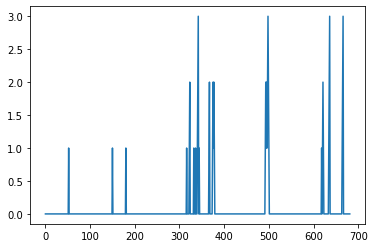

In [ ]:
slow_logger.samples_df["len"].plot()

In [ ]:
trim_slow = slow_logger.samples_df[0:-1]

<ipython-input-268-be15909547e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trim_slow["Q(t)"] = trim_slow["len"] * trim_slow["time_span"]


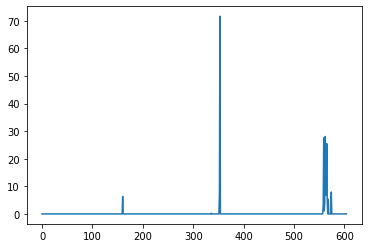

In [ ]:
trim_slow["Q(t)"] = trim_slow["len"] * trim_slow["time_span"]
trim_slow["Q(t)"].plot()

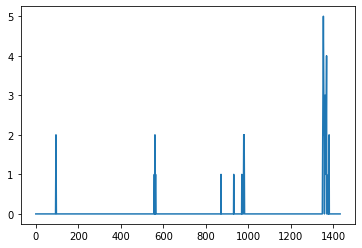

In [ ]:
fast_logger.samples_df["len"].plot()

In [ ]:
trim_fast = fast_logger.samples_df[0:-1]

<ipython-input-271-799275e5480e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trim_fast["Q(t)"] = trim_fast["len"] * trim_fast["time_span"]


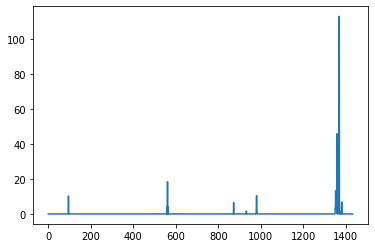

In [ ]:
trim_fast["Q(t)"] = trim_fast["len"] * trim_fast["time_span"]
trim_fast["Q(t)"].plot()